In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
def vis_viva(mu, r, a):
    """
    Calculate the orbital speed at a distance r from the focus, for an elliptical orbit with semi-major axis a.
    
    Parameters:
    - mu (float): Standard gravitational parameter (G*M where G is the gravitational constant and M is the mass of the central body).
    - r (float): Current distance from the central body.
    - a (float): Semi-major axis of the orbit.
    
    Returns:
    - float: Orbital speed at distance r.
    """
    v = np.sqrt(2 * mu / r - mu / a)
    return v

def hohmann(mu, ri, ai, rf, af):
    """
    Calculate the total delta-v required for a Hohmann transfer between two orbits.

    Parameters:
    - mu (float): Standard gravitational parameter.
    - ri (float): Radius at the departure point in the initial orbit.
    - ai (float): Semi-major axis of the initial orbit.
    - rf (float): Radius at the arrival point in the final orbit.
    - af (float): Semi-major axis of the final orbit.

    Returns:
    - float: Total delta-v required for the transfer.
    """
    at = (ri + rf) / 2  # Semi-major axis of the transfer orbit
    del_vi = vis_viva(mu, ri, at) - vis_viva(mu, ri, ai)  # Delta-v at the departure point
    del_vf = vis_viva(mu, rf, af) - vis_viva(mu, rf, at)  # Delta-v at the arrival point
    del_v = np.abs(del_vi) + np.abs(del_vf)  # Total delta-v for the maneuver
    return del_v

def low_thrust_transfer(mu, ri, ai, rf, af):
    """
    Calculate the total delta-v required for a low-thrust transfer between two orbits.

    Parameters:
    - mu (float): Standard gravitational parameter.
    - ri (float): Radius at the departure point in the initial orbit.
    - ai (float): Semi-major axis of the initial orbit.
    - rf (float): Radius at the arrival point in the final orbit.
    - af (float): Semi-major axis of the final orbit.

    Returns:
    - float: Total delta-v required for the transfer.
    """
    del_v = np.abs(vis_viva(mu, ri, ai) - vis_viva(mu, rf, af))
    return del_v

In [31]:
isp_elec = 1640  # in seconds
isp_chem = 300  # in seconds
c_elec = 9.81 * isp_elec  # in m/s
c_chem = 9.81 * isp_chem  # in m/s
P = 1190  # Input power in Watt
alpha = 0.08  # specific mass

mps = alpha * P  # mass of the power system
ms = 170  # mass of the structure
mpay = 20  # mass of the payload

delv_tot = 2000  # total delta-V in m/s
fep = 0.1  # EP fraction

delta_v_hoh_vec_CE = (1 - fep) * delv_tot
delta_v_lt_vec_CE = fep * delv_tot

m0 = 300  # initial guess for total mass

for i in range(100):
    mp_chem = m0 * (1 - np.exp(-delta_v_hoh_vec_CE / c_chem))
    mp_elec = (m0 - mp_chem) * (1 - np.exp(-delta_v_lt_vec_CE / c_elec))  # Adjusted for iterative change

    m0_new = ms + mpay + mps + mp_elec + mp_chem

    if abs(m0_new - m0) < 1e-3:  # Convergence condition
        break

    m0 = m0_new  # Update mass for next iteration

H_hyb=(mpay+ms)/m0

print(f"Converged total mass: {m0:.3f} kg after {i+1} iterations")
print("H_hyb=",H_hyb)


Converged total mass: 532.318 kg after 17 iterations
H_hyb= 0.3569296063636108


## GEO to Lunar orbit
### 1- Hohmann transfer to an intermediate orbit followed by low-thrust transfer

In [32]:
# Constants
mu = 3.986e14  # Standard gravitational parameter for Earth in m^3/s^2
R_E = 6378e3   # Earth's radius in meters

# Orbital radii
ri = R_E + 35786e3   # Radius at periapsis of GEO in meters
ai = ri   # Semi-major axis of GEO in meters (circular orbit)
rf = R_E + 400000e3 # Radius at apoapsis of Lunar orbit in meters
af = rf # Semi-major axis of Lunar orbit in meters (circular orbit)

In [33]:
# Calculate the delta-v for a Hohmann transfer from GEO to lunar:
delta_v_hoh = hohmann(mu, ri, ai, rf, af)
print("Total delta-v for the Hohmann transfer (i.e.: f_el=0%):", delta_v_hoh, "m/s")

delta_v_lt = low_thrust_transfer(mu, ri, ai, rf, af)
print("Total delta-v for the lowthrust trasnfer (i.e.: f_el=100%):", delta_v_lt , "m/s")

Total delta-v for the Hohmann transfer (i.e.: f_el=0%): 1625.1112375298567 m/s
Total delta-v for the lowthrust trasnfer (i.e.: f_el=100%): 2084.280723102989 m/s


In [34]:
switch_points=np.linspace(ri, rf, 1000)

delta_v_hoh_vec_CE=hohmann(mu, ri, ai, switch_points, switch_points)
delta_v_lt_vec_CE=low_thrust_transfer(mu, switch_points, switch_points, rf,af)

total_delv_CE=delta_v_hoh_vec_CE+delta_v_lt_vec_CE
ep_fraction_CE=delta_v_lt_vec_CE/total_delv_CE

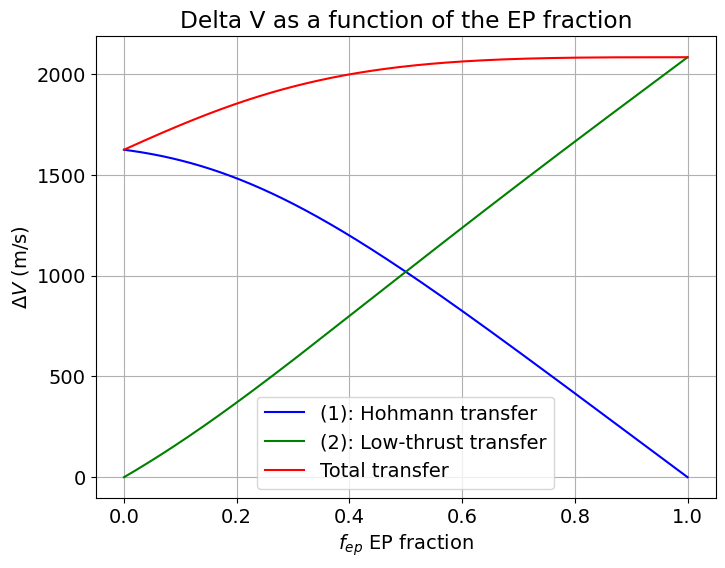

In [35]:
plt.figure(figsize=(8, 6), dpi=100)
plt.rcParams['font.size'] = 14
plt.plot(ep_fraction_CE,delta_v_hoh_vec_CE,'b',label="(1): Hohmann transfer")
plt.plot(ep_fraction_CE,delta_v_lt_vec_CE,'g',label="(2): Low-thrust transfer")
plt.plot(ep_fraction_CE,total_delv_CE,'r',label="Total transfer")
plt.grid(True)    
plt.title(f"Delta V as a function of the EP fraction")
plt.xlabel("$f_{ep}$ EP fraction")  # Add an x-axis label
plt.ylabel(r"$\Delta V$ (m/s)")
plt.legend(loc='best', fontsize=14)

In [36]:
isp_elec = 1640  # in seconds
isp_chem = 300  # in seconds
c_elec = 9.81 * isp_elec  # in m/s
c_chem = 9.81 * isp_chem  # in m/s
P = 1190  # Input power in Watt
alpha = 0.08  # specific mass

mps = alpha * P  # mass of the power system
ms = 170  # mass of the structure
mpay = 50  # mass of the payload


In [37]:
# Initialize m0 as an array
N = len(delta_v_hoh_vec_CE)  # Number of cases
m0_CE = np.full(N, 300.0)  # Initial guess for all cases
mp_chem_CE = np.full(N, 300.0)
mp_elec_CE = np.full(N, 300.0)

for i in range(N):

    while True:  # Maximum 100 iterations
        mp_chem_CE[i] = m0_CE[i] * (1 - np.exp(-delta_v_hoh_vec_CE[i] / c_chem))
        mp_elec_CE[i] = (m0_CE[i] - mp_chem_CE[i]) * (1 - np.exp(-delta_v_lt_vec_CE[i] / c_elec))  # Adjusted for iterative change
        m0_new = ms + mpay + mps + mp_elec_CE[i] + mp_chem_CE[i]

        # Convergence check for all cases at once
        if np.all(np.abs(m0_new - m0_CE[i]) < 1e-3):
            break

        m0_CE[i] = m0_new  # Update mass for next iteration



Text(0, 0.5, 'Mass $(kg)$')

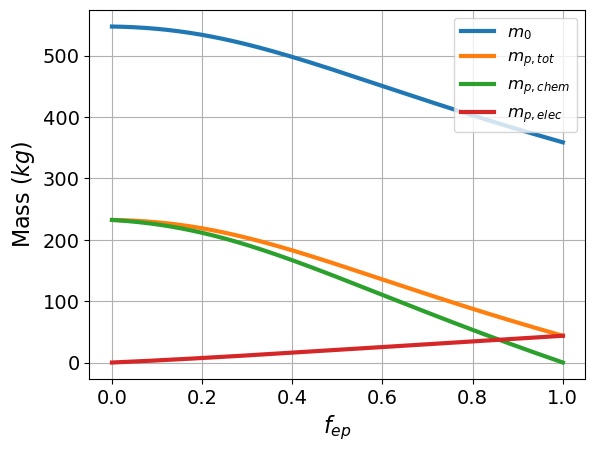

In [38]:
plt.plot(ep_fraction_CE,m0_CE,lw=3,label=r"$m_0$")
plt.plot(ep_fraction_CE,mp_chem_CE+mp_elec_CE,lw=3,label=r"$m_{p,tot}$")
plt.plot(ep_fraction_CE,mp_chem_CE,lw=3,label=r"$m_{p,chem}$")
plt.plot(ep_fraction_CE,mp_elec_CE,lw=3,label=r"$m_{p,elec}$")

plt.grid(True)
plt.legend(loc='upper right', fontsize=12)
plt.xlabel(r'$f_{ep}$',fontsize=16)  
plt.ylabel(r'Mass $(kg)$',fontsize=16)  

### 2- Low-thrust transfer to an intermediate orbit  followed by a Hohmann transfer. 

In [39]:
delta_v_lt_vec_EC= low_thrust_transfer(mu, ri, ai, switch_points, switch_points)
delta_v_hoh_vec_EC= hohmann(mu, switch_points, switch_points, rf,af)

total_delv_EC=delta_v_hoh_vec_EC+delta_v_lt_vec_EC
ep_fraction_EC=delta_v_lt_vec_EC/total_delv_EC

<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
/var/folders/xc/wwmv09fx49ldb0xqhs8v6zsm0000gn/T/ipykernel_66929/3525600385.py:11: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta V$ (m/s)")


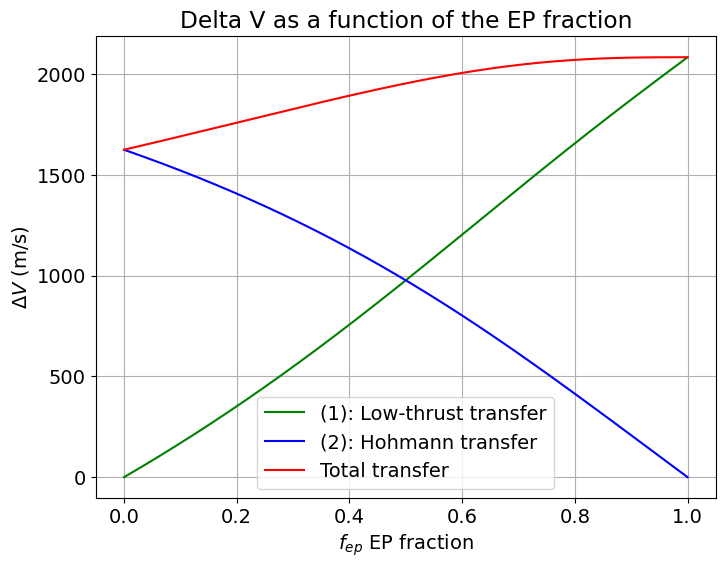

In [40]:
plt.figure(figsize=(8, 6), dpi=100)
plt.rcParams['font.size'] = 14
plt.plot(ep_fraction_EC,delta_v_lt_vec_EC,'g',label="(1): Low-thrust transfer")
plt.plot(ep_fraction_EC,delta_v_hoh_vec_EC,'b',label="(2): Hohmann transfer")
plt.plot(ep_fraction_EC,total_delv_EC,'r',label="Total transfer")


plt.grid(True)    
plt.title(f"Delta V as a function of the EP fraction")
plt.xlabel("$f_{ep}$ EP fraction")  # Add an x-axis label
plt.ylabel("$\Delta V$ (m/s)")
plt.legend(loc='best', fontsize=14)

In [41]:
# Initialize m0 as an array
N = len(delta_v_hoh_vec_EC)  # Number of cases
m0_EC = np.full(N, 300.0)  # Initial guess for all cases
mp_chem_EC = np.full(N, 300.0)
mp_elec_EC = np.full(N, 300.0)

for i in range(N):

    while True:  
        mp_elec_EC[i] = m0_EC[i] * (1 - np.exp(-delta_v_lt_vec_EC[i] / c_elec))  # Adjusted for iterative change
        mp_chem_EC[i] = (m0_EC[i]-mp_elec_EC[i]) * (1 - np.exp(-delta_v_hoh_vec_EC[i] / c_chem))
        m0_new = ms + mpay + mps + mp_elec_EC[i] + mp_chem_EC[i]

        # Convergence check for all cases at once
        if np.all(np.abs(m0_new - m0_EC[i]) < 1e-3):
            break

        m0_EC[i] = m0_new  # Update mass for next iteration


Text(0, 0.5, 'Mass $(kg)$')

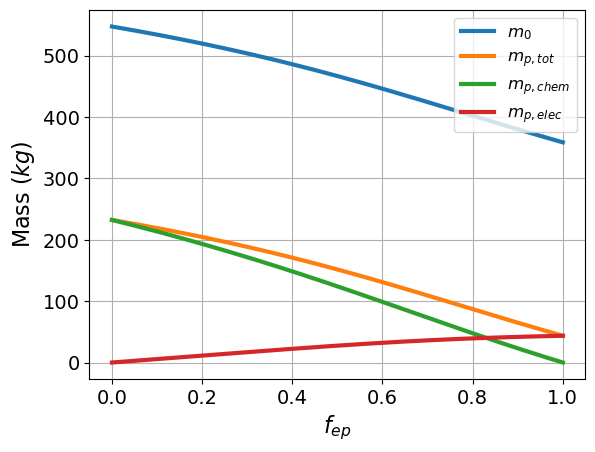

In [42]:
plt.plot(ep_fraction_EC,m0_EC,lw=3,label=r"$m_0$")
plt.plot(ep_fraction_EC,mp_chem_EC+mp_elec_EC,lw=3,label=r"$m_{p,tot}$")
plt.plot(ep_fraction_EC,mp_chem_EC,lw=3,label=r"$m_{p,chem}$")
plt.plot(ep_fraction_EC,mp_elec_EC,lw=3,label=r"$m_{p,elec}$")

plt.grid(True)
plt.legend(loc='upper right', fontsize=12)
plt.xlabel(r'$f_{ep}$',fontsize=16)  
plt.ylabel(r'Mass $(kg)$',fontsize=16)  

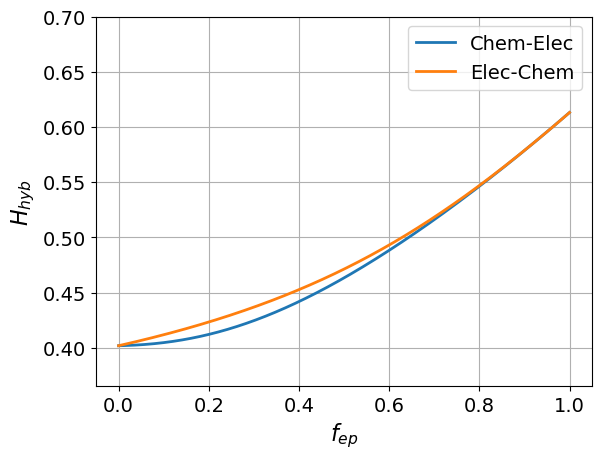

In [43]:
plt.plot(ep_fraction_CE,(mpay+ms)/m0_CE,lw=2,label=r"Chem-Elec")
plt.plot(ep_fraction_EC,(mpay+ms)/m0_EC,lw=2,label=r"Elec-Chem")
plt.grid(True)
plt.xlabel(r'$f_{ep}$',fontsize=16)  
plt.ylabel(r'$H_{hyb}$',fontsize=16)  
plt.ylim([0.365,0.7])
plt.legend()

## Fix the total mass and vary the payload mass

In [44]:
m0=366.9
mps = alpha * P  # mass of the power system
ms=167.7  # mass of the structure


# Initialize m0 as an array
N = len(delta_v_hoh_vec_EC)  # Number of cases

mp_chem_CE = np.full(N, 300.0)
mp_elec_CE = np.full(N, 300.0)
mpay_CE = np.full(N, 300.0)  # Initial guess for all cases

for i in range(N):
    
    mp_chem_CE[i] = m0 * (1 - np.exp(-delta_v_hoh_vec_CE[i] / c_chem))
    mp_elec_CE[i] = (m0-mp_chem_CE[i]) * (1 - np.exp(-delta_v_lt_vec_CE[i] / c_elec))  # Adjusted for iterative change
    mpay_CE[i]=m0-(ms+mps+mp_chem_CE[i]+mp_elec_CE[i])




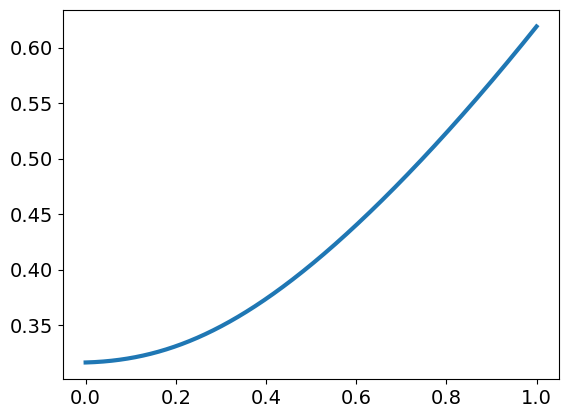

In [58]:
plt.plot(ep_fraction_CE,(mpay_CE+ms)/m0,lw=3)


In [46]:
print("Mass Budget:")
print("Total mass=",m0)
print("Structure mass=",ms)
print("power system mass=",mps)

Mass Budget:
Total mass= 366.9
Structure mass= 167.7
power system mass= 95.2


Text(0, 0.5, 'Mass $(kg)$')

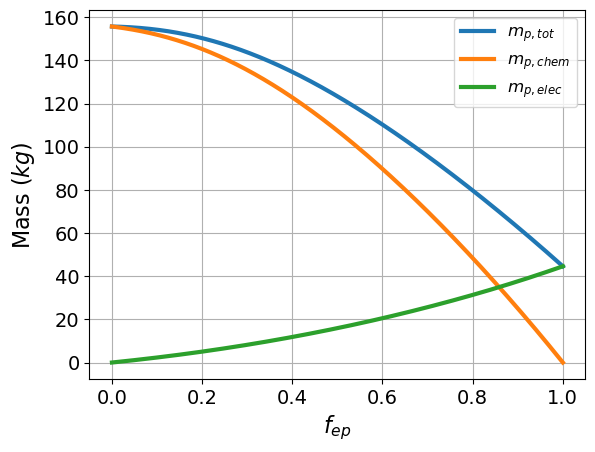

In [47]:
plt.plot(ep_fraction_CE,mp_chem_CE+mp_elec_CE,lw=3,label=r"$m_{p,tot}$")
plt.plot(ep_fraction_CE,mp_chem_CE,lw=3,label=r"$m_{p,chem}$")
plt.plot(ep_fraction_CE,mp_elec_CE,lw=3,label=r"$m_{p,elec}$")

plt.grid(True)
plt.legend(loc='upper right', fontsize=12)
plt.xlabel(r'$f_{ep}$',fontsize=16)  
plt.ylabel(r'Mass $(kg)$',fontsize=16)  

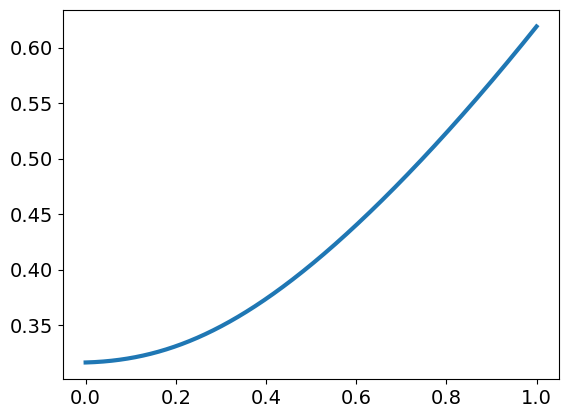

In [59]:
plt.plot(ep_fraction_CE,1-(mp_chem_CE+mp_elec_CE+mps)/m0,lw=3,label=r"$m_{p,tot}$")